In [ ]:
!pip install -q git+https://github.com/bowang-lab/MedSAM.git


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 406.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.3/52.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.7/515.7 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.8/385.8 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 86.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.4 MB/s eta 0:00:00
   ━━━━━

In [ ]:
!pip uninstall -y scipy
!pip install scipy==1.12.0


Found existing installation: scipy 1.14.1
Uninstalling scipy-1.14.1:
  Successfully uninstalled scipy-1.14.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 13.0 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F


In [ ]:
# Visualization functions
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251/255, 252/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='blue', facecolor=(0,0,0,0), lw=2))

@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]
    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None, boxes=box_torch, masks=None)
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),
        sparse_prompt_embeddings=sparse_embeddings,
        dense_prompt_embeddings=dense_embeddings,
        multimask_output=False,
    )
    low_res_pred = torch.sigmoid(low_res_logits)
    low_res_pred = F.interpolate(
        low_res_pred, size=(H, W), mode="bilinear", align_corners=False)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()
    return (low_res_pred > 0.5).astype(np.uint8)

def compute_bbox_from_mask(mask):
    if len(mask.shape) == 3:
        mask_gray = np.mean(mask, axis=-1)
    else:
        mask_gray = mask
    binary = mask_gray > 0
    coords = np.column_stack(np.where(binary))
    if coords.size == 0:
        return None
    y0, x0 = coords.min(axis=0)
    y1, x1 = coords.max(axis=0)
    return np.array([x0, y0, x1, y1])


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Set dataset paths (adjust if necessary)
images_dir = "/content/drive/MyDrive/OTU_2d/images"
annots_dir = "/content/drive/MyDrive/OTU_2d/annotations"


Mounted at /content/drive


In [ ]:
!wget -O medsam_vit_b.pth https://zenodo.org/records/10689643/files/medsam_vit_b.pth


--2025-04-24 11:28:43--  https://zenodo.org/records/10689643/files/medsam_vit_b.pth
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375049145 (358M) [application/octet-stream]
Saving to: ‘medsam_vit_b.pth’

medsam_vit_b.pth    100%[===================>] 357.67M   714KB/s    in 8m 51s  

2025-04-24 11:37:35 (689 KB/s) - ‘medsam_vit_b.pth’ saved [375049145/375049145]



In [ ]:
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0" if torch.cuda.is_available() else "cpu"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()


Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d()
    )


In [ ]:
# from google.colab import files
# uploaded = files.upload()

In [ ]:
def calculate_iou(mask1, mask2):
    """Calculate IoU between two binary masks"""
    if len(mask1.shape) == 3:
        mask1 = (np.mean(mask1, axis=2) > 0).astype(np.uint8)
    if len(mask2.shape) == 3:
        mask2 = (np.mean(mask2, axis=2) > 0).astype(np.uint8)

    mask1_binary = mask1 > 0
    mask2_binary = mask2 > 0

    intersection = np.logical_and(mask1_binary, mask2_binary).sum()
    union = np.logical_or(mask1_binary, mask2_binary).sum()

    if union == 0:
        return 0.0

    return intersection / union

In [ ]:
from tqdm import tqdm  # for progress bar

# Get list of image files (assumed to be .JPG; adjust if needed)
image_files = sorted([f for f in os.listdir(images_dir) if f.lower().endswith('.jpg')])
dataset_results = []  # List to hold tuples: (image filename, original image, annotation mask, segmentation, iou)
iou_scores = []  # List to collect all IoU scores

# Iterate over images with a progress bar
for img_file in tqdm(image_files, desc="Processing images"):
    base_name = os.path.splitext(img_file)[0]  # e.g., "1" from "1.JPG"
    annot_file = base_name + ".PNG"             # annotation file like "1.PNG"

    img_path = os.path.join(images_dir, img_file)
    annot_path = os.path.join(annots_dir, annot_file)

    # Load image
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    orig_H, orig_W, _ = img_3c.shape

    # Load annotation mask; skip if not found
    if not os.path.exists(annot_path):
        print(f"Annotation {annot_path} not found; skipping {img_file}.")
        continue
    annot = io.imread(annot_path)

    # Compute bounding box from the annotation mask (using "X.PNG")
    bbox = compute_bbox_from_mask(annot)
    if bbox is None:
        print(f"No foreground in annotation {annot_path}; skipping {img_file}.")
        continue
    box_np = bbox.reshape(1, 4)  # For later visualization

    # Preprocess image: resize to 1024x1024 and normalize to [0, 1]
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

    # Scale bounding box from original dimensions to 1024x1024
    box_1024 = box_np / np.array([orig_W, orig_H, orig_W, orig_H]) * 1024

    # Run inference
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, orig_H, orig_W)

    # Calculate IoU for this sample
    iou = calculate_iou(annot, medsam_seg)
    iou_scores.append(iou)

    # Save results
    dataset_results.append((img_file, img_3c, annot, medsam_seg, iou))

Processing images: 100%|██████████| 1469/1469 [1:07:53<00:00,  2.77s/it]


In [ ]:
# Calculate mean IoU across all samples
miou = np.mean(iou_scores)

# Print IoU results
print(f"Mean IoU (mIoU): {miou:.4f}")
print("\nIndividual IoU scores:")
for i, (img_file, _, _, _, iou) in enumerate(dataset_results):
    print(f"{img_file}: IoU = {iou:.4f}")

Mean IoU (mIoU): 0.8283

Individual IoU scores:
1.JPG: IoU = 0.9049
10.JPG: IoU = 0.8943
100.JPG: IoU = 0.9065
1000.JPG: IoU = 0.8059
1001.JPG: IoU = 0.7748
1002.JPG: IoU = 0.8758
1003.JPG: IoU = 0.7952
1004.JPG: IoU = 0.8208
1005.JPG: IoU = 0.5976
1006.JPG: IoU = 0.9061
1007.JPG: IoU = 0.8976
1008.JPG: IoU = 0.8333
1009.JPG: IoU = 0.4355
101.JPG: IoU = 0.8556
1010.JPG: IoU = 0.8923
1011.JPG: IoU = 0.9071
1012.JPG: IoU = 0.9535
1013.JPG: IoU = 0.9375
1014.JPG: IoU = 0.3336
1015.JPG: IoU = 0.7579
1016.JPG: IoU = 0.7770
1017.JPG: IoU = 0.8683
1018.JPG: IoU = 0.7661
1019.JPG: IoU = 0.8683
102.JPG: IoU = 0.8799
1020.JPG: IoU = 0.8607
1021.JPG: IoU = 0.7245
1022.JPG: IoU = 0.8375
1023.JPG: IoU = 0.8894
1024.JPG: IoU = 0.7992
1025.JPG: IoU = 0.7174
1026.JPG: IoU = 0.8976
1027.JPG: IoU = 0.8893
1028.JPG: IoU = 0.9641
1029.JPG: IoU = 0.8787
103.JPG: IoU = 0.8535
1030.JPG: IoU = 0.8662
1031.JPG: IoU = 0.8443
1032.JPG: IoU = 0.8931
1033.JPG: IoU = 0.7875
1034.JPG: IoU = 0.8686
1035.JPG: IoU = 0.

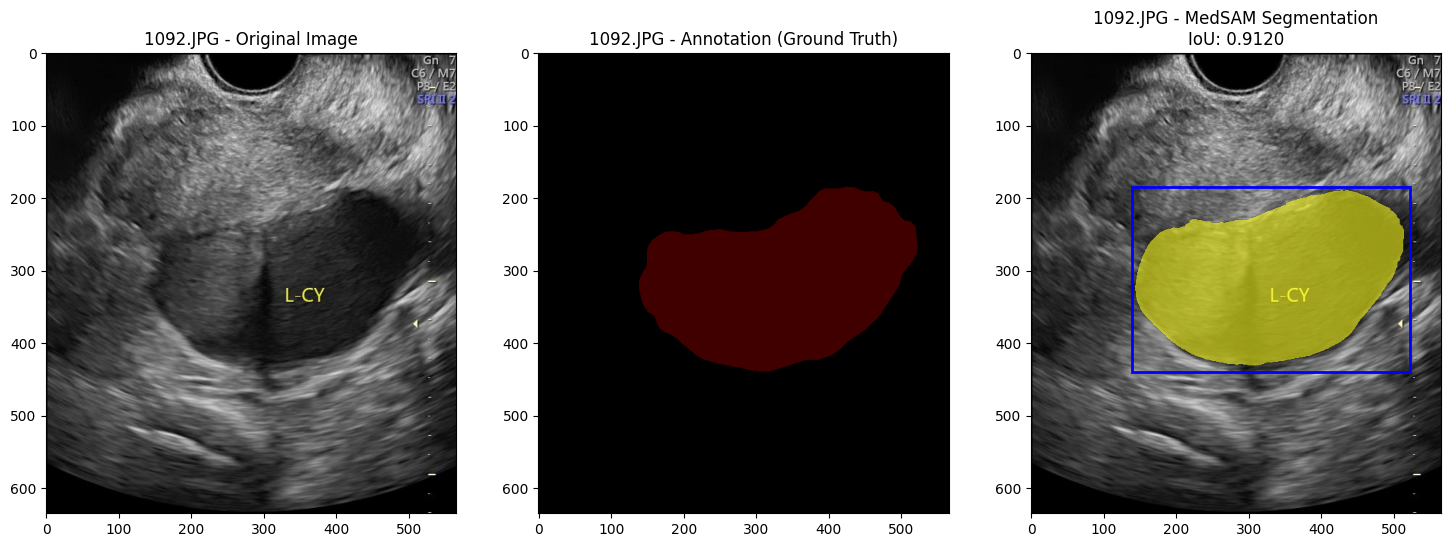

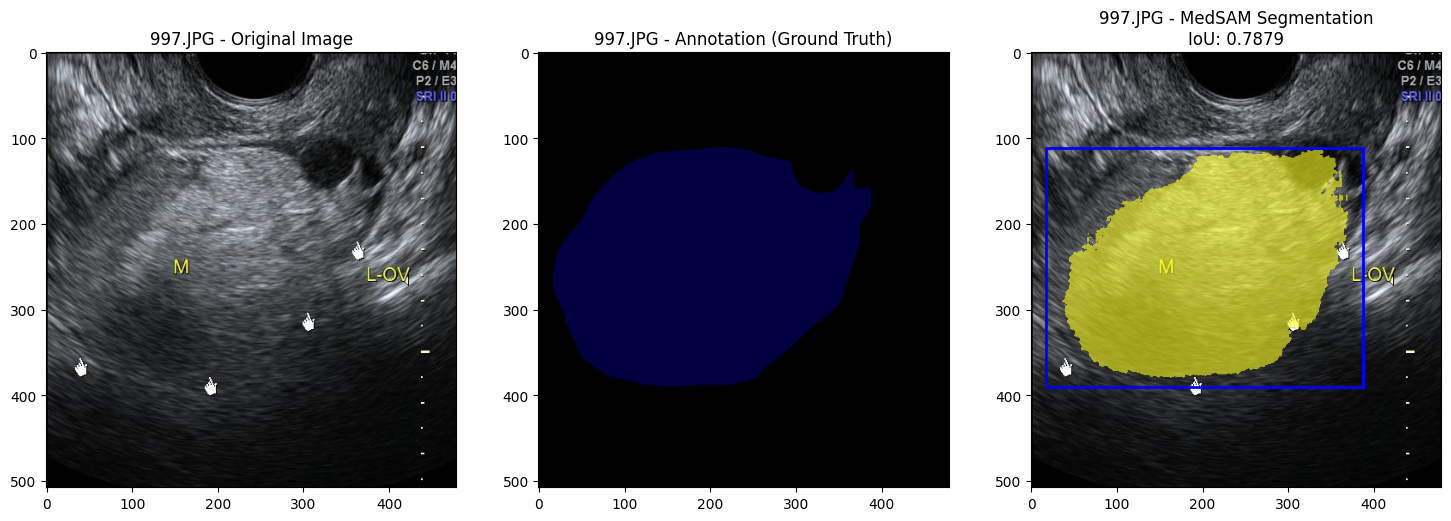

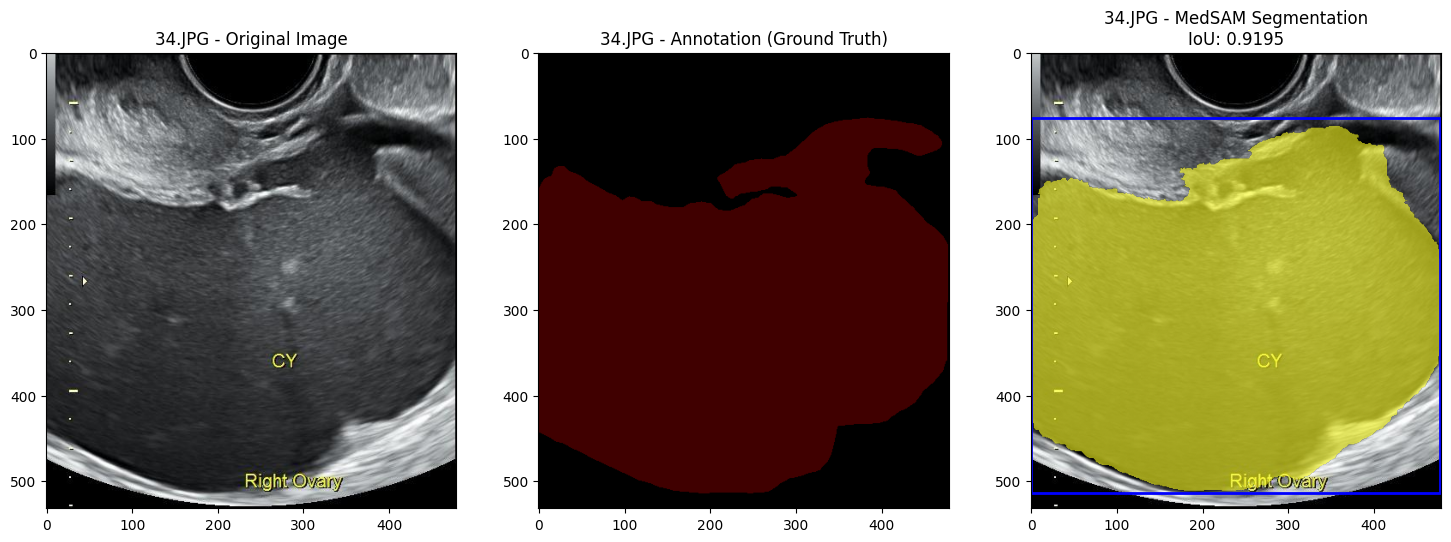

In [ ]:
import random

# Select up to 3 random samples from the processed results
num_samples = min(3, len(dataset_results))
samples = random.sample(dataset_results, num_samples)

for (img_file, orig_img, annot, medsam_seg, iou) in samples:
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))

    # Original image
    ax[0].imshow(orig_img)
    ax[0].set_title(f"{img_file} - Original Image")

    # Ground truth annotation mask
    ax[1].imshow(annot, cmap='gray')
    ax[1].set_title(f"{img_file} - Annotation (Ground Truth)")

    # MedSAM segmentation overlay
    ax[2].imshow(orig_img)
    show_mask(medsam_seg, ax[2])
    # Optionally, overlay the computed bounding box from annotation
    bbox = compute_bbox_from_mask(annot)
    if bbox is not None:
        show_box(bbox, ax[2])
    ax[2].set_title(f"{img_file} - MedSAM Segmentation\nIoU: {iou:.4f}")

    plt.show()

In [ ]:
# Save the model state dictionary
torch.save(medsam_model.state_dict(), "/content/medsam_model_state.pth")

# Save results (assuming dataset_results is a list of tuples)
import pickle
with open("/content/medsam_results.pkl", "wb") as f:
    pickle.dump(dataset_results, f)


In [ ]:

# !pip install -q nibabel

##NIFTI Segmentation using point clicking based input

In [ ]:
# Interactive Image Upload and Click-Based Segmentation (Fixed Version)
# Run this in a new cell

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from skimage import transform
import torch
import os
import ipywidgets as widgets
from IPython.display import display, clear_output
from PIL import Image
from datetime import datetime
import io

# Ensure output directory exists
output_dir = "/content/output_images"
os.makedirs(output_dir, exist_ok=True)

# Global variables
uploaded_image = None
click_coords = []
current_box = None
current_mask = None
device = "cuda:0" if torch.cuda.is_available() else "cpu"
img_width = 500  # Default width for display
img_height = 500  # Default height for display

# Create widgets
upload_button = widgets.FileUpload(
    accept='image/*',
    multiple=False,
    description='Upload Image'
)

click_x = widgets.IntText(
    value=0,
    description='X:',
    disabled=False
)

click_y = widgets.IntText(
    value=0,
    description='Y:',
    disabled=False
)

add_point_button = widgets.Button(
    description='Add Point',
    button_style='info',
    icon='plus'
)

clear_button = widgets.Button(
    description='Clear Points',
    button_style='warning',
    icon='eraser'
)

segment_button = widgets.Button(
    description='Segment',
    button_style='primary',
    icon='check'
)

save_button = widgets.Button(
    description='Save Result',
    button_style='success',
    icon='save',
    disabled=True
)

image_output = widgets.Output()
status_label = widgets.HTML(
    value="<b>Instructions:</b> Upload an image, enter coordinates to create points, then click Segment."
)

# Interactive canvas to select points
canvas_width = 500
canvas_height = 500
canvas = widgets.Image(
    format='png',
    width=canvas_width,
    height=canvas_height,
)

# Function to handle image upload
def on_upload_change(change):
    global uploaded_image, click_coords, current_box, current_mask, img_width, img_height

    if not change.new:
        return

    # Reset state
    click_coords = []
    current_box = None
    current_mask = None
    save_button.disabled = True

    # Get uploaded file data
    uploaded_file = list(change.new.values())[0]
    content = uploaded_file['content']

    # Load image with PIL
    image = Image.open(io.BytesIO(content))

    # Resize for display while maintaining aspect ratio
    original_width, original_height = image.size
    aspect_ratio = original_width / original_height

    if aspect_ratio > 1:
        # Width is greater than height
        img_width = canvas_width
        img_height = int(canvas_width / aspect_ratio)
    else:
        # Height is greater than width
        img_height = canvas_height
        img_width = int(canvas_height * aspect_ratio)

    # Resize image for display
    display_image = image.resize((img_width, img_height))

    # Convert to numpy array for processing
    uploaded_image = np.array(image)

    # If image has an alpha channel, remove it
    if uploaded_image.shape[-1] == 4:
        uploaded_image = uploaded_image[..., :3]

    # If image is grayscale, convert to RGB
    if len(uploaded_image.shape) == 2:
        uploaded_image = np.stack([uploaded_image] * 3, axis=-1)

    # Update the canvas
    bio = io.BytesIO()
    display_image.save(bio, format='PNG')
    canvas.value = bio.getvalue()

    # Update coordinates range
    click_x.max = original_width - 1
    click_y.max = original_height - 1

    status_label.value = "<b>Image loaded.</b> Enter X,Y coordinates and click 'Add Point' to mark areas of interest."

    # Update the visualization
    update_visualization()

# Function to add a point
def on_add_point(b):
    global click_coords

    if uploaded_image is None:
        status_label.value = "<b>Error:</b> Please upload an image first."
        return

    # Add the point
    x = click_x.value
    y = click_y.value
    click_coords.append((x, y))

    # Update visualization
    update_visualization()

    status_label.value = f"<b>Point added:</b> ({x}, {y}). {len(click_coords)} points total."

# Function to update the visualization
def update_visualization():
    global uploaded_image, click_coords, current_box

    if uploaded_image is None:
        return

    with image_output:
        clear_output(wait=True)

        # Create figure
        fig, ax = plt.subplots(figsize=(10, 10))

        # Display image
        ax.imshow(uploaded_image)

        # Draw points
        for i, (x, y) in enumerate(click_coords):
            ax.plot(x, y, 'ro', markersize=8)
            ax.text(x+5, y+5, f"{i+1}", color='white', fontsize=12, weight='bold')

        # Create bounding box if at least 2 points
        if len(click_coords) >= 2:
            x_coords = [p[0] for p in click_coords]
            y_coords = [p[1] for p in click_coords]
            x0, y0 = min(x_coords), min(y_coords)
            x1, y1 = max(x_coords), max(y_coords)

            # Draw rectangle
            rect = Rectangle((x0, y0), x1-x0, y1-y0, linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

            # Update current box
            current_box = np.array([[x0, y0, x1, y1]])

        ax.set_title(f"Image with {len(click_coords)} selected points")
        plt.tight_layout()
        plt.show()

# Function to handle clear points
def on_clear_points(b):
    global click_coords, current_box, current_mask
    click_coords = []
    current_box = None
    current_mask = None
    save_button.disabled = True
    update_visualization()
    status_label.value = "<b>Points cleared.</b> Enter new coordinates to create points."

# Function to segment image based on clicks
def on_segment(b):
    global uploaded_image, click_coords, current_box, current_mask

    if uploaded_image is None:
        status_label.value = "<b>Error:</b> Please upload an image first."
        return

    if len(click_coords) < 2:
        status_label.value = "<b>Error:</b> Need at least 2 points to create a bounding box."
        return

    # Create bounding box from clicks (already done in update_visualization)
    if current_box is None:
        x_coords = [p[0] for p in click_coords]
        y_coords = [p[1] for p in click_coords]
        x0, y0 = min(x_coords), min(y_coords)
        x1, y1 = max(x_coords), max(y_coords)
        current_box = np.array([[x0, y0, x1, y1]])

    # Prepare image for MedSAM
    H, W = uploaded_image.shape[:2]
    img_1024 = transform.resize(
        uploaded_image, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)

    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )

    img_1024_tensor = (
        torch.from_numpy(img_1024)
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
    )

    # Inference with MedSAM
    status_label.value = "<b>Processing:</b> Running MedSAM segmentation..."

    box_np = current_box
    box_1024 = box_np / np.array([W, H, W, H]) * 1024

    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    current_mask = medsam_seg

    with image_output:
        clear_output(wait=True)

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Original image with box
        ax1.imshow(uploaded_image)
        show_box(box_np[0], ax1)
        ax1.set_title("Original Image with Box")

        # Segmented image
        ax2.imshow(uploaded_image)
        show_mask(medsam_seg, ax2)
        show_box(box_np[0], ax2)
        ax2.set_title("MedSAM Segmentation")

        plt.tight_layout()
        plt.show()

    # Enable save button
    save_button.disabled = False
    status_label.value = "<b>Segmentation complete!</b> You can save the result or try different points."

# Function to save segmentation results
def on_save_result(b):
    global uploaded_image, current_box, current_mask

    if current_mask is None:
        status_label.value = "<b>Error:</b> No segmentation to save. Please segment the image first."
        return

    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save original image with box
    fig_orig = plt.figure(figsize=(8, 8))
    ax_orig = fig_orig.add_subplot(111)
    ax_orig.imshow(uploaded_image)
    show_box(current_box[0], ax_orig)
    ax_orig.set_title("Original Image with Box")
    ax_orig.axis('off')
    plt.tight_layout()
    original_filename = os.path.join(output_dir, f"uploaded_original_{timestamp}.png")
    fig_orig.savefig(original_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_orig)

    # Save segmented image
    fig_seg = plt.figure(figsize=(8, 8))
    ax_seg = fig_seg.add_subplot(111)
    ax_seg.imshow(uploaded_image)
    show_mask(current_mask, ax_seg)
    show_box(current_box[0], ax_seg)
    ax_seg.set_title("MedSAM Segmentation")
    ax_seg.axis('off')
    plt.tight_layout()
    segmented_filename = os.path.join(output_dir, f"uploaded_segmented_{timestamp}.png")
    fig_seg.savefig(segmented_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_seg)

    # Save mask only
    fig_mask = plt.figure(figsize=(8, 8))
    ax_mask = fig_mask.add_subplot(111)
    mask_visible = np.zeros((*current_mask.shape, 4))
    mask_visible[..., 0] = 1  # Red channel
    mask_visible[..., 3] = current_mask  # Alpha channel
    ax_mask.imshow(mask_visible)
    ax_mask.set_title("Segmentation Mask Only")
    ax_mask.axis('off')
    plt.tight_layout()
    mask_filename = os.path.join(output_dir, f"uploaded_mask_only_{timestamp}.png")
    fig_mask.savefig(mask_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_mask)

    # Display confirmation
    status_label.value = f"<b>Images saved to {output_dir}:</b><br>" \
                        f"1. {os.path.basename(original_filename)}<br>" \
                        f"2. {os.path.basename(segmented_filename)}<br>" \
                        f"3. {os.path.basename(mask_filename)}"

# Connect widget events
upload_button.observe(on_upload_change, names='value')
add_point_button.on_click(on_add_point)
clear_button.on_click(on_clear_points)
segment_button.on_click(on_segment)
save_button.on_click(on_save_result)

# Create UI layout
coordinate_input = widgets.HBox([click_x, click_y, add_point_button])
button_row = widgets.HBox([upload_button, clear_button, segment_button, save_button])
ui = widgets.VBox([
    button_row,
    coordinate_input,
    status_label,
    image_output
])

# Display UI
display(ui)

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving suj01-DC.nii to suj01-DC.nii


In [ ]:
pip install ipywidgets


In [ ]:
%matplotlib inline


In [ ]:
pip install nibabel scikit-image opencv-python torch


##NIFTI Segmentation using bounding box coordinated without visualization features

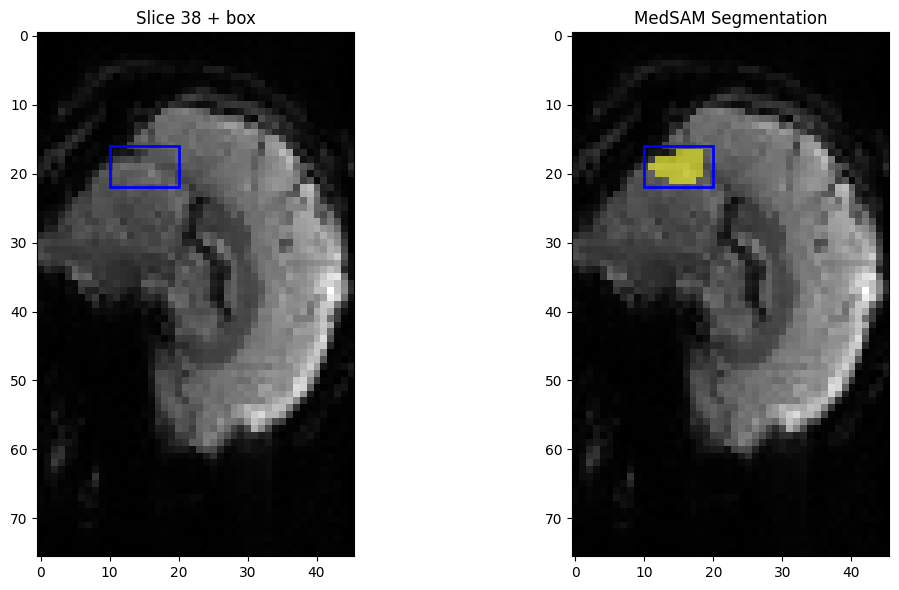

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import torch
from segment_anything import sam_model_registry

# (Assume medsam_inference, show_box, and show_mask are defined.)

#%% Load MedSAM model
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH).to(device).eval()

#%% Load NIfTI
nifti_path = "/content/suj01-DC.nii"
nii = nib.load(nifti_path)
vol = nii.get_fdata().astype(np.float32)  # could be (X,Y,Z) or (X,Y,Z,T)

# If there’s a time dimension (4D), pick the first volume
if vol.ndim == 4:
    vol = vol[..., 0]  # now (X, Y, Z)

# Decide on axis order: nibabel returns (i,j,k) which we’ll treat as (Z, H, W)
# If shape is (H, W, D), swap axes so axis 0 is slice-index:
if vol.shape[0] < vol.shape[-1] and vol.shape[1] < vol.shape[-1]:
    # likely (H, W, D)
    vol = np.transpose(vol, (2, 0, 1))  # now (D, H, W)

# Now vol is (D, H, W)
D, H, W = vol.shape

#%% Select a slice
slice_idx = D // 2
img = vol[slice_idx]  # shape (H, W)

#%% Normalize & to uint8
img_norm = (img - img.min()) / (img.max() - img.min()) * 255.0
img_uint8 = img_norm.astype(np.uint8)

# Convert to 3‑channel
img_3c = np.stack([img_uint8]*3, axis=-1)  # shape (H, W, 3)

#%% Resize & normalize for SAM
img_1024 = transform.resize(
    img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(
    img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
)

img_1024_tensor = (
    torch.from_numpy(img_1024)
    .float()
    .permute(2, 0, 1)
    .unsqueeze(0)
    .to(device)
)

#%% Prompt: a bounding box in original (W,H)
box_np = np.array([[10, 16, 20, 22]])  # [x0,y0,x1,y1]
box_1024 = box_np / np.array([W, H, W, H]) * 1024

#%% Inference
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)

medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

#%% Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(img_3c, cmap='gray')
show_box(box_np[0], ax[0])
ax[0].set_title(f"Slice {slice_idx} + box")
ax[1].imshow(img_3c, cmap='gray')
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.tight_layout()
plt.show()


##NIFTI Segmentation using bounding box coordinated with visualization features

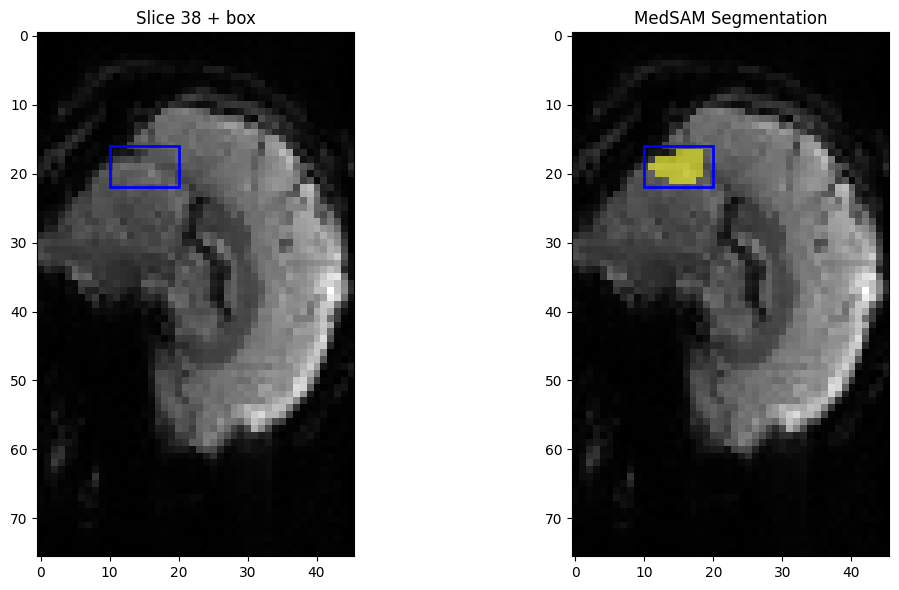

In [ ]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from skimage import transform
import torch
from segment_anything import sam_model_registry
import ipywidgets as widgets
from IPython.display import display
from scipy.ndimage import rotate as rotate_image
import os
from datetime import datetime
from matplotlib.backends.backend_agg import FigureCanvasAgg

# Install ipywidgets if not already installed
!pip install -q ipywidgets

# (Assume medsam_inference, show_box, and show_mask are defined)

#%% Load MedSAM model
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH).to(device).eval()

#%% Load NIfTI
nifti_path = "/content/suj01-DC.nii"
nii = nib.load(nifti_path)
vol = nii.get_fdata().astype(np.float32)  # could be (X,Y,Z) or (X,Y,Z,T)

# If there's a time dimension (4D), pick the first volume
if vol.ndim == 4:
    vol = vol[..., 0]  # now (X, Y, Z)

# Decide on axis order: nibabel returns (i,j,k) which we'll treat as (Z, H, W)
# If shape is (H, W, D), swap axes so axis 0 is slice-index:
if vol.shape[0] < vol.shape[-1] and vol.shape[1] < vol.shape[-1]:
    # likely (H, W, D)
    vol = np.transpose(vol, (2, 0, 1))  # now (D, H, W)

# Now vol is (D, H, W)
D, H, W = vol.shape

# Make sure the output directory exists
output_dir = "/content/output_images"
os.makedirs(output_dir, exist_ok=True)

# Global variables for transformations
flip_h = False
flip_v = False
rotation_angle = 0
zoom_factor = 1.0
current_slice = D // 2
current_fig = None
current_img = None
current_mask = None
current_box = None

# Function to apply transformations to image and box
def apply_transformations(img, box=None):
    global flip_h, flip_v, rotation_angle, zoom_factor

    # Create a copy to avoid modifying the original
    transformed_img = img.copy()
    transformed_box = box.copy() if box is not None else None

    # Apply flips
    if flip_h:
        transformed_img = np.fliplr(transformed_img)
        if transformed_box is not None:
            # For horizontal flip, swap x coordinates and adjust
            x0, y0, x1, y1 = transformed_box[0]
            transformed_box[0] = [W - x1, y0, W - x0, y1]

    if flip_v:
        transformed_img = np.flipud(transformed_img)
        if transformed_box is not None:
            # For vertical flip, swap y coordinates and adjust
            x0, y0, x1, y1 = transformed_box[0]
            transformed_box[0] = [x0, H - y1, x1, H - y0]

    # Apply rotation
    if rotation_angle != 0:
        # Rotate image
        transformed_img = rotate_image(transformed_img, rotation_angle, reshape=False, order=1)

        if transformed_box is not None:
            # For rotation, we need to adjust the box
            # This is simplified and might not be perfect for large rotations
            center_x, center_y = W/2, H/2
            x0, y0, x1, y1 = transformed_box[0]

            # Convert to center and dimensions
            box_center_x = (x0 + x1) / 2
            box_center_y = (y0 + y1) / 2
            box_width = x1 - x0
            box_height = y1 - y0

            # Calculate distance from center
            dx = box_center_x - center_x
            dy = box_center_y - center_y

            # Calculate new center based on rotation
            angle_rad = np.radians(rotation_angle)
            new_dx = dx * np.cos(angle_rad) - dy * np.sin(angle_rad)
            new_dy = dx * np.sin(angle_rad) + dy * np.cos(angle_rad)

            new_center_x = center_x + new_dx
            new_center_y = center_y + new_dy

            # Create new box
            new_x0 = new_center_x - box_width / 2
            new_y0 = new_center_y - box_height / 2
            new_x1 = new_center_x + box_width / 2
            new_y1 = new_center_y + box_height / 2

            transformed_box[0] = [new_x0, new_y0, new_x1, new_y1]

    # Zoom is handled in the display function

    return transformed_img, transformed_box

# Function to process the slice and run segmentation
def process_slice(slice_idx):
    global zoom_factor, rotation_angle, flip_h, flip_v

    # Get the selected slice
    img = vol[slice_idx]  # shape (H, W)

    # Normalize & to uint8
    img_norm = (img - img.min()) / (img.max() - img.min()) * 255.0
    img_uint8 = img_norm.astype(np.uint8)

    # Convert to 3-channel
    img_3c = np.stack([img_uint8]*3, axis=-1)  # shape (H, W, 3)

    # Apply transformations for display only
    transformed_img, _ = apply_transformations(img_3c)

    # Resize & normalize for SAM - use original (non-transformed) image
    img_1024 = transform.resize(
        img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )

    img_1024_tensor = (
        torch.from_numpy(img_1024)
        .float()
        .permute(2, 0, 1)
        .unsqueeze(0)
        .to(device)
    )

    # Prompt: a bounding box in original (W,H)
    box_np = np.array([[10, 16, 20, 22]])  # [x0,y0,x1,y1]
    box_1024 = box_np / np.array([W, H, W, H]) * 1024

    # Inference
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)

    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

    # Apply transformations to the mask and box for display
    transformed_img, transformed_box = apply_transformations(img_3c, box_np)
    transformed_mask = apply_transformations(medsam_seg, None)[0]

    return transformed_img, transformed_box, transformed_mask

# Function to save the current visualization as PNG
def save_images(b):
    global current_slice, current_img, current_mask, current_box

    # Generate timestamp for unique filenames
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

    # Save original image with box
    fig_orig = plt.figure(figsize=(6, 6))
    ax_orig = fig_orig.add_subplot(111)
    ax_orig.imshow(current_img, cmap='gray')
    show_box(current_box[0], ax_orig)
    ax_orig.set_title(f"Slice {current_slice} + box")
    ax_orig.axis('off')
    plt.tight_layout()
    original_filename = os.path.join(output_dir, f"slice_{current_slice}_original_{timestamp}.png")
    fig_orig.savefig(original_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_orig)

    # Save segmented image
    fig_seg = plt.figure(figsize=(6, 6))
    ax_seg = fig_seg.add_subplot(111)
    ax_seg.imshow(current_img, cmap='gray')
    show_mask(current_mask, ax_seg)
    show_box(current_box[0], ax_seg)
    ax_seg.set_title("MedSAM Segmentation")
    ax_seg.axis('off')
    plt.tight_layout()
    segmented_filename = os.path.join(output_dir, f"slice_{current_slice}_segmented_{timestamp}.png")
    fig_seg.savefig(segmented_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_seg)

    # Save mask only
    fig_mask = plt.figure(figsize=(6, 6))
    ax_mask = fig_mask.add_subplot(111)
    mask_visible = np.zeros((*current_mask.shape, 4))
    mask_visible[..., 0] = 1  # Red channel
    mask_visible[..., 3] = current_mask  # Alpha channel
    ax_mask.imshow(mask_visible)
    ax_mask.set_title("Segmentation Mask Only")
    ax_mask.axis('off')
    plt.tight_layout()
    mask_filename = os.path.join(output_dir, f"slice_{current_slice}_mask_only_{timestamp}.png")
    fig_mask.savefig(mask_filename, dpi=150, bbox_inches='tight')
    plt.close(fig_mask)

    # Display confirmation message
    save_status.value = f"Images saved to {output_dir}:<br>" \
                        f"1. {os.path.basename(original_filename)}<br>" \
                        f"2. {os.path.basename(segmented_filename)}<br>" \
                        f"3. {os.path.basename(mask_filename)}"

# Create the interactive visualization
def update_visualization(slice_idx, zoom, rotation, flip_horizontal, flip_vertical):
    global current_slice, zoom_factor, rotation_angle, flip_h, flip_v
    global current_fig, current_img, current_mask, current_box

    # Update global variables
    current_slice = slice_idx
    zoom_factor = zoom
    rotation_angle = rotation
    flip_h = flip_horizontal
    flip_v = flip_vertical

    # Process the slice with transformations
    img_3c, box_np, medsam_seg = process_slice(slice_idx)

    # Update current state for saving
    current_img = img_3c
    current_mask = medsam_seg
    current_box = box_np

    # Create visualization
    current_fig = plt.figure(figsize=(12, 6))
    gs = GridSpec(1, 2, figure=current_fig)
    ax1 = current_fig.add_subplot(gs[0, 0])
    ax2 = current_fig.add_subplot(gs[0, 1])

    # Original image + box
    ax1.imshow(img_3c, cmap='gray')
    show_box(box_np[0], ax1)
    ax1.set_title(f"Slice {slice_idx} + box")

    # Image + mask + box
    ax2.imshow(img_3c, cmap='gray')
    show_mask(medsam_seg, ax2)
    show_box(box_np[0], ax2)
    ax2.set_title("MedSAM Segmentation")

    # Apply zoom to both axes
    xlim = ax1.get_xlim()
    ylim = ax1.get_ylim()
    center_x = (xlim[0] + xlim[1]) / 2
    center_y = (ylim[0] + ylim[1]) / 2
    width = (xlim[1] - xlim[0]) / zoom_factor
    height = (ylim[1] - ylim[0]) / zoom_factor

    # Set new limits for both axes
    ax1.set_xlim(center_x - width/2, center_x + width/2)
    ax1.set_ylim(center_y - height/2, center_y + height/2)
    ax2.set_xlim(center_x - width/2, center_x + width/2)
    ax2.set_ylim(center_y - height/2, center_y + height/2)

    plt.tight_layout()
    plt.show()

# Create widgets
slice_slider = widgets.IntSlider(
    value=D//2,
    min=0,
    max=D-1,
    step=1,
    description='Slice:',
    continuous_update=False
)

zoom_slider = widgets.FloatSlider(
    value=1.0,
    min=0.5,
    max=5.0,
    step=0.1,
    description='Zoom:',
    continuous_update=False
)

rotation_slider = widgets.FloatSlider(
    value=0,
    min=-180,
    max=180,
    step=5,
    description='Rotation:',
    continuous_update=False
)

flip_h_checkbox = widgets.Checkbox(
    value=False,
    description='Flip Horizontal',
)

flip_v_checkbox = widgets.Checkbox(
    value=False,
    description='Flip Vertical',
)

reset_button = widgets.Button(
    description='Reset View',
    button_style='warning'
)

save_button = widgets.Button(
    description='Save Images',
    button_style='success',
    icon='save'
)

save_status = widgets.HTML(
    value="",
    description="",
    style={'description_width': '0px'}
)

# Define reset function
def reset_view(b):
    global current_slice, zoom_factor, rotation_angle, flip_h, flip_v
    slice_slider.value = D // 2
    zoom_slider.value = 1.0
    rotation_slider.value = 0
    flip_h_checkbox.value = False
    flip_v_checkbox.value = False
    save_status.value = ""

reset_button.on_click(reset_view)
save_button.on_click(save_images)

# Create interactive output
interactive_output = widgets.interactive_output(
    update_visualization,
    {
        'slice_idx': slice_slider,
        'zoom': zoom_slider,
        'rotation': rotation_slider,
        'flip_horizontal': flip_h_checkbox,
        'flip_vertical': flip_v_checkbox
    }
)

# Layout for the widgets
controls = widgets.VBox([
    widgets.HBox([slice_slider]),
    widgets.HBox([zoom_slider]),
    widgets.HBox([rotation_slider]),
    widgets.HBox([flip_h_checkbox, flip_v_checkbox]),
    widgets.HBox([reset_button, save_button]),
    save_status
])

# Display the widgets and output
display(widgets.VBox([controls, interactive_output]))

# Initialize the visualization
update_visualization(D//2, 1.0, 0, False, False)

##DICOM Segmentation

In [ ]:
#  from google.colab import files

# uploaded = files.upload()

Saving MR000000.dcm to MR000000.dcm


In [ ]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 37.7 MB/s eta 0:00:00


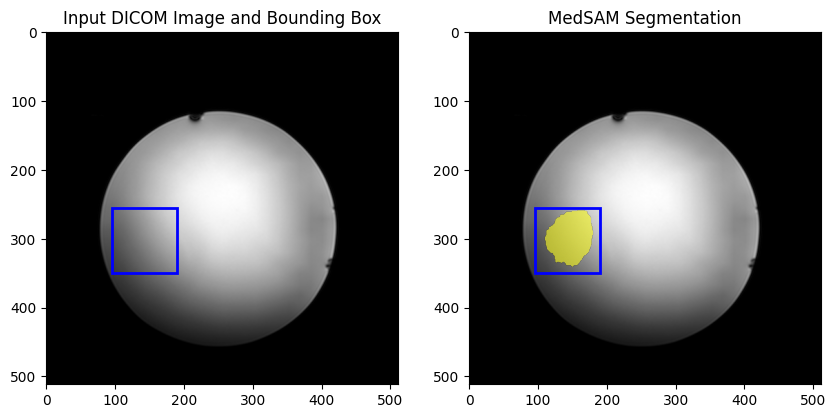

In [ ]:
#%% Import necessary libraries
import pydicom
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
import torch
from segment_anything import sam_model_registry

# (Assume medsam_inference, show_box, and show_mask functions are already defined.)

#%% Load MedSAM model
MedSAM_CKPT_PATH = "/content/medsam_vit_b.pth"
device = "cuda:0"
medsam_model = sam_model_registry['vit_b'](checkpoint=MedSAM_CKPT_PATH)
medsam_model = medsam_model.to(device)
medsam_model.eval()

#%% Load and preprocess the DICOM image
dicom_path = "/content/MR000000.dcm"  # Update with your DICOM file path
ds = pydicom.dcmread(dicom_path)
img = ds.pixel_array.astype(np.float32)

# If available, apply rescale slope and intercept (common in CT images)
if hasattr(ds, 'RescaleSlope') and hasattr(ds, 'RescaleIntercept'):
    img = img * ds.RescaleSlope + ds.RescaleIntercept

# Normalize pixel values to the range [0, 255] and convert to uint8
img_norm = (img - np.min(img)) / (np.max(img) - np.min(img)) * 255.0
img_uint8 = img_norm.astype(np.uint8)

# Convert to 3-channel image if the DICOM is grayscale
if len(img_uint8.shape) == 2:
    img_3c = np.repeat(img_uint8[:, :, None], 3, axis=-1)
else:
    img_3c = img_uint8

H, W, _ = img_3c.shape

#%% Image preprocessing and model inference
# Resize the image to 1024x1024
img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
img_1024 = (img_1024 - img_1024.min()) / np.clip(img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None)  # normalize to [0, 1]

# Convert to tensor and adjust shape to (1, 3, H, W)
img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)

# Define a bounding box (adjust as necessary) and scale it to 1024x1024
box_np = np.array([[95, 255, 190, 350]])
box_1024 = box_np / np.array([W, H, W, H]) * 1024

# Encode the image and run the segmentation inference
with torch.no_grad():
    image_embedding = medsam_model.image_encoder(img_1024_tensor)  # shape (1, 256, 64, 64)
medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

#%% Visualize the results
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_3c)
show_box(box_np[0], ax[0])
ax[0].set_title("Input DICOM Image and Bounding Box")
ax[1].imshow(img_3c)
show_mask(medsam_seg, ax[1])
show_box(box_np[0], ax[1])
ax[1].set_title("MedSAM Segmentation")
plt.show()
